- OneCycle
- augmentated TTA
- no TTA for val

# start

In [1]:
class Param: pass
param = Param()

#########################
param.PRFX = 'Mel0718A1'#
#########################

param.PRFX_B4 = None; param.FLD2USE_B4 = 0
param.ARCH = 'efficientnet-b3'

param.SZ = 512 
param.PRFX_PREP = 'MelPrp0909C512' 

param.EPOCHS = 10

param.BS = 32
param.SEED = 101; 

param.K=5; 
param.FLDS2USE = range(param.K)
param.FP16 = True
param.PLTFACTOR=0.5; param.PATIENCE=5; param.MIN_LR=1e-8

param.RandomResizedCrop_scale=(0.75, 1.0)
param.N_TTA = 20

param.LR=1e-3
param.WD=0

param.N_SAMPL = None

param.DEBUG = False
if param.DEBUG: 
    param.N_TTA = 2
    param.EPOCHS = 2
    param.FLDS2USE = [0,1]
    param.N_SAMPL = 1024

DEVICE = 'cuda'; 
if DEVICE=='cpu': param.FP16 = False
PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

param.__dict__

{'PRFX': 'Mel0718A1',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'ARCH': 'efficientnet-b3',
 'SZ': 512,
 'PRFX_PREP': 'MelPrp0909C512',
 'EPOCHS': 10,
 'BS': 32,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(0, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 20,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [2]:
!nvidia-smi

Sun Jul 19 12:49:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   53C    P0    58W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

import pretrainedmodels
from efficientnet_pytorch import EfficientNet
import cv2
import albumentations as A
from albumentations import pytorch as AT

from apex import amp

import warnings; warnings.filterwarnings("ignore")


def sigmoid(x): return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out = f'../output/{param.PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'
if param.PRFX_B4 is not None: p_b4  = f'../output/{param.PRFX_B4}'


# prep

In [4]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 
print(dftrn.shape)

set_seed(param.SEED); dftrn = dftrn.sample(frac=1.)

if param.N_SAMPL is not None: dftrn = dftrn.head(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58032, 4)


,source,im_pth,patient_id,target
23539,20,../output/MelPrp0909C512/siim-isic-melanoma-cl...,IP_2618037,0.0
48725,19,../output/MelPrp0909C512/andrewmvd--isic-2019/...,BCN_0000529,0.0


(58032, 4)

20    32701
19    25331
Name: source, dtype: int64

source
19    0.178516
20    0.017767
Name: target, dtype: float64

## folds

In [5]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

2084


In [6]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl=list(kf.split(dftrn, groups=dftrn.patient_id))

for fld, (tr, vl) in enumerate(fld2trvl):
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())

0 46425 11607
1 46425 11607
2 46426 11606
3 46426 11606
4 46426 11606


0.0    0.912159
1.0    0.087841
Name: target, dtype: float64

0.0    0.911922
1.0    0.088078
Name: target, dtype: float64

0.0    0.911903
1.0    0.088097
Name: target, dtype: float64

0.0    0.910697
1.0    0.089303
Name: target, dtype: float64

0.0    0.913648
1.0    0.086352
Name: target, dtype: float64

20    26172
19    20253
Name: source, dtype: int64

20    26147
19    20278
Name: source, dtype: int64

20    26171
19    20255
Name: source, dtype: int64

20    26137
19    20289
Name: source, dtype: int64

20    26177
19    20249
Name: source, dtype: int64

In [7]:
display(dftrn.source.value_counts())
idx20 = np.where(dftrn.source==20)[0]
len(idx20)

20    32701
19    25331
Name: source, dtype: int64

32701

In [8]:
fld2vl20 = []
for tr, vl in fld2trvl:
    vl20 = np.array([o for o in vl if o in idx20])
    print(len(vl), len(vl20))
    fld2vl20.append(vl20)

11607 6529
11607 6554
11606 6530
11606 6564
11606 6524


## testset

In [9]:
dftst = pd.read_csv(f'{p_prp}/test.csv', nrows=128 if param.DEBUG else None) 
display(dftst.head(3))

dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=128 if param.DEBUG else None) 

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0909C512/siim-isic-melanoma-cl...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0909C512/siim-isic-melanoma-cl...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0909C512/siim-isic-melanoma-cl...


# dataset

In [10]:
class MelDataset(Dataset):
    def __init__(self, df, mode='trn'):
        self.df = df
        self.mode = mode
        if self.mode == 'val':
            self.composed = A.Compose([
                A.Resize(param.SZ,param.SZ),
                A.Normalize(), 
                AT.ToTensor(),
            ]) 
        else:
            self.composed = A.Compose([
                A.RandomResizedCrop(param.SZ,param.SZ, scale=param.RandomResizedCrop_scale),
                A.Transpose(),
                A.Flip(),
                A.Rotate(360),
                A.OneOf([A.RandomBrightnessContrast(), A.CLAHE(),]),
                A.HueSaturationValue(hue_shift_limit=3, sat_shift_limit=3),
                A.OneOf([A.Blur(blur_limit=2), A.IAASharpen()]),
                A.Normalize(), 
                AT.ToTensor(),
            ])    
    def __getitem__(self, i):
        x = cv2.imread(self.df.im_pth.values[i]) 
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = self.composed(image=x)['image']
        if self.mode =='trn':
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

In [11]:
if param.DEBUG: 
    dstst = MelDataset(dftst, mode='tst')
    i = np.random.choice(len(dstst))
    print(dstst[i][0].shape)


In [12]:
# better comment out A.Normalize() when showing 
if param.DEBUG:
    plt.imshow(dstst[i][0].permute(1, 2, 0))

## test ds

In [13]:
dstst = MelDataset(dftst, mode='tst')
print(len(dstst))
dltst = DataLoader(dstst, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

10982
172


# model

In [14]:
def mkmdl():  
    mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
    return mdl

In [15]:
mdl = mkmdl()

Loaded pretrained weights for efficientnet-b3


## focal loss

In [16]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=3, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

def loss_fn(outputs, targets):
    return FocalLoss()(outputs, targets.view(-1, 1))

# train

## TTA

In [17]:
# def evaluate(model, dl):
#     model.eval()
#     prd = []
#     y = []
#     for step, dat in enumerate(dl):
#         xb, yb = (o.to(device) for o in dat)
#         with torch.no_grad(): prdb = model(xb)
#         prd.append(prdb.cpu().detach().numpy())
#         y.append(yb.cpu().detach().numpy())
#     prd = np.concatenate(prd)    
#     y = np.concatenate(y)    
#     lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
#     scr = roc_auc(y, prd)
#     return lss, scr, y, prd

In [18]:
def evaluate(model, dl):
    model.eval()
    prd=[]
    y=[]
    for step, dat in enumerate(dl):
        xb, yb = (o.to(device) for o in dat)
        with torch.no_grad(): prdb = model(xb)
        prd.append(prdb.cpu().detach().numpy())
        y.append(yb.cpu().detach().numpy())
    prd = np.concatenate(prd)    
    y = np.concatenate(y)    
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

## infer

In [19]:
def infer(model, dl):
    model.eval()
    prd=[]
    for i in range(param.N_TTA):
        prdi = []
        for step, dat in enumerate(dl):
            xb=dat[0].to(device)
            with torch.no_grad(): 
                prdb = model(xb)
            prdi.append(prdb.cpu().detach().numpy())
        prdi = np.concatenate(prdi)    
        prd.append(prdi)
    prd = np.mean(prd, 0)
    return prd

## set up data

In [20]:
def getdls(fld):
    tr,vl=fld2trvl[fld]
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    ystr=dftr.target.values
    ysvl=dfvl.target.values
    dstr = MelDataset(dftr, mode='trn')
    dsvl = MelDataset(dfvl, mode='trn')
    dltr = DataLoader(dstr, batch_size=param.BS,       shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl = DataLoader(dsvl, batch_size=param.BS*2,     shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    return dltr,dlvl

## run train

In [21]:
set_seed(param.SEED)

results = {}
results['fld2trvl'] = fld2trvl
results['param'] = param
results['fld2stats']={}

for fld in param.FLDS2USE:
    
    tr,vl=fld2trvl[fld]
    dltr,dlvl=getdls(fld)
    print(f'fld:{fld};', 'dltr,dlvl:', len(dltr), len(dlvl))

    mdl = mkmdl().to(device)
    if param.PRFX_B4 is not None: 
        fnm_mdl_b4 = f'{p_b4}/model_{param.PRFX_B4}_fld_{param.fld}_best.p'
        print('load previously trained', fnm_mdl_b4)
        mdl.load_state_dict(torch.load(fnm_mdl_b4, map_location=torch.device(DEVICE)))
    # opt = optim.SGD(mdl.parameters(), lr=param.LR, momentum=param.MOMENTUM, weight_decay=param.WD)
    opt = optim.Adam(mdl.parameters(), lr=param.LR, weight_decay=param.WD)
#     schdl = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=param.PLTFACTOR, patience=param.PATIENCE, min_lr=param.MIN_LR, verbose=True)
    schdl = optim.lr_scheduler.OneCycleLR(opt, max_lr=param.LR, total_steps=param.EPOCHS*len(dltr))
    if param.FP16: mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)
    mdl.zero_grad()

        

    stats = {
    'lss': {'tr':[],'vl':[],},
    'scr': {'tr':[],'vl':[],},
    }
    ep2oof = []

    best_scr = float('-inf')
    best_epc = -1    
    
    for epc in range(param.EPOCHS):
        prdtr_ep=[]
        ytr_ep=[]
        for step, dat in enumerate(dltr):
            mdl.train()
            xb,yb=(o.to(device) for o in dat)
            yb = yb.unsqueeze(1)
            prdb = mdl(xb)
    #         loss = F.binary_cross_entropy_with_logits(prdb, yb)
            loss =  loss_fn(prdb,yb)
            if param.FP16:
                with amp.scale_loss(loss, opt) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            if param.FP16:
                torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
            else:
                torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
            opt.step()
            opt.zero_grad()
            prdtr_ep.append(prdb.cpu().detach().numpy())
            ytr_ep.append(yb.cpu().detach().numpy())
            if step>0 and step%1000==0: print(dtnow(), f'ep {epc} step {step}/{len(dltr)}')

        prdtr_ep = np.concatenate(prdtr_ep)
        ytr_ep = np.concatenate(ytr_ep)    
        lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
        scr_tr_ep = roc_auc(ytr_ep, prdtr_ep)
        stats['lss']['tr'].append(lss_tr_ep)
        stats['scr']['tr'].append(scr_tr_ep)

        lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
        stats['lss']['vl'].append(lss_vl_ep)
        stats['scr']['vl'].append(scr_vl_ep)
        ep2oof.append(prdvl_ep)

        print(dtnow(), f'fld {fld} ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; ')

        if epc>=3 and (scr_vl_ep>best_scr or epc>=param.EPOCHS-3):
            prdtst = infer(mdl, dltst)
            dfsub.target = sigmoid(prdtst)
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv', index=False)
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_epc_{epc}.p')

        if scr_vl_ep>best_scr:
            print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
            best_scr = scr_vl_ep
            best_epc = epc
            if epc>=3: 
                torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best.p')
                dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv', index=False)

        schdl.step(scr_vl_ep)  # Update learning rate schedule
        
        stats['best_scr'] = best_scr
        stats['best_epc'] = best_epc
        results['fld2stats'][fld] = stats
        pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  
    pickle.dump(ep2oof, open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'wb'))  

fld:0; dltr,dlvl: 1451 182
Loaded pretrained weights for efficientnet-b3
2020-07-19 12:59:19 ep 0 step 1000/1451
2020-07-19 13:05:09 fld 0 ep 0: lss_tr 0.380; lss_vl 0.356; scr_tr 0.859; scr_vl 0.893; 
better scr -inf -> 0.893
2020-07-19 13:14:56 ep 1 step 1000/1451
2020-07-19 13:20:37 fld 0 ep 1: lss_tr 0.339; lss_vl 0.322; scr_tr 0.906; scr_vl 0.907; 
better scr 0.893 -> 0.907
2020-07-19 13:30:20 ep 2 step 1000/1451
2020-07-19 13:36:06 fld 0 ep 2: lss_tr 0.320; lss_vl 0.305; scr_tr 0.922; scr_vl 0.911; 
better scr 0.907 -> 0.911
2020-07-19 13:45:54 ep 3 step 1000/1451
2020-07-19 13:51:36 fld 0 ep 3: lss_tr 0.306; lss_vl 0.297; scr_tr 0.935; scr_vl 0.912; 
better scr 0.911 -> 0.912
2020-07-19 14:27:34 ep 4 step 1000/1451
2020-07-19 14:33:14 fld 0 ep 4: lss_tr 0.286; lss_vl 0.271; scr_tr 0.946; scr_vl 0.918; 
better scr 0.912 -> 0.918
2020-07-19 15:08:04 ep 5 step 1000/1451
2020-07-19 15:13:48 fld 0 ep 5: lss_tr 0.275; lss_vl 0.271; scr_tr 0.952; scr_vl 0.920; 
better scr 0.918 -> 0.92

Traceback (most recent call last):
  File "/data/anaconda3/envs/mel/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/data/anaconda3/envs/mel/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/data/anaconda3/envs/mel/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/data/anaconda3/envs/mel/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [22]:
pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  

# training trajec

KeyError: 2

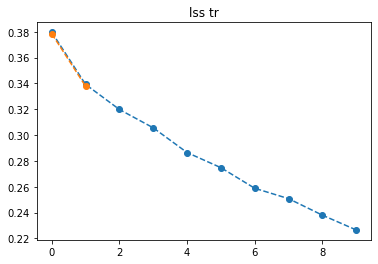

In [23]:
for mtrc in ['lss', 'scr']:
    for k in ['tr','vl',]:
        plt.title(f'{mtrc} {k}')
        for fld in param.FLDS2USE:
            plt.plot(results['fld2stats'][fld][mtrc][k], 'o--')
        plt.show()

# oofs

In [24]:
vls = []
for fld in param.FLDS2USE:
    _,vl=fld2trvl[fld]
    vls += list(vl)
len(vls), vls[:10]

(58032, [0, 13, 16, 19, 27, 29, 31, 54, 55, 60])

## only last epoch 

In [25]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:,-1])
    oofs += list(oof)
    
roc_auc(dftrn.target.iloc[vls], oofs)

FileNotFoundError: [Errno 2] No such file or directory: '../output/Mel0718A1/ep2oof_Mel0718A1_fld_1.p'

In [26]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

IndexError: index 11607 is out of bounds for axis 0 with size 11607

## only best_scr epoch

In [27]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    best_epc = results['fld2stats'][fld]['best_epc']
    oof = list(ep2oof[:,best_epc])
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

FileNotFoundError: [Errno 2] No such file or directory: '../output/Mel0718A1/ep2oof_Mel0718A1_fld_1.p'

In [28]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

IndexError: index 11607 is out of bounds for axis 0 with size 11607

## avg all epochs

In [29]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof.mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

FileNotFoundError: [Errno 2] No such file or directory: '../output/Mel0718A1/ep2oof_Mel0718A1_fld_1.p'

In [30]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

IndexError: index 11607 is out of bounds for axis 0 with size 11607

## avg last m epochs

In [31]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:, -3:].mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

FileNotFoundError: [Errno 2] No such file or directory: '../output/Mel0718A1/ep2oof_Mel0718A1_fld_1.p'

In [32]:
oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20])

IndexError: index 11607 is out of bounds for axis 0 with size 11607

In [33]:
def get_oof_avg_last_m(m):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, -m:].mean(1))
        oofs += list(oof)
    return oofs

In [34]:
for m in range(1, 3):
    oofs = get_oof_avg_last_m(m)
    oof_sorted = np.array([o[1] for o in sorted(zip(vls,oofs))])
    print(m, f'{roc_auc(dftrn.target.iloc[vls], oofs):.3f}', 
          f'{roc_auc(dftrn.target.iloc[idx20], oof_sorted[idx20]):.3f}')


FileNotFoundError: [Errno 2] No such file or directory: '../output/Mel0718A1/ep2oof_Mel0718A1_fld_1.p'

# submissions

## only last epoch

In [35]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{param.EPOCHS-1}.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 0 0.1498221077016662


,image_name,target
0,ISIC_0052060,0.061489
1,ISIC_0052349,0.036925
2,ISIC_0058510,0.033268


FileNotFoundError: [Errno 2] File ../output/Mel0718A1/submission_Mel0718A1_fld_1_epc_9.csv does not exist: '../output/Mel0718A1/submission_Mel0718A1_fld_1_epc_9.csv'

0.14982210770166637


,image_name,target
0,ISIC_0052060,0.061489
1,ISIC_0052349,0.036925
2,ISIC_0058510,0.033268


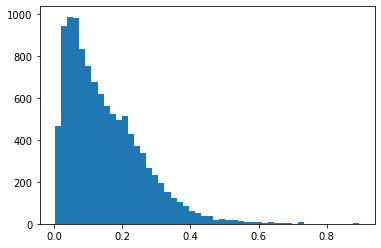

In [36]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [37]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlylast.csv', index=False)

## only best_scr epoch

In [38]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 0 0.1659156011378618


,image_name,target
0,ISIC_0052060,0.061286
1,ISIC_0052349,0.051215
2,ISIC_0058510,0.028347


FileNotFoundError: [Errno 2] File ../output/Mel0718A1/submission_Mel0718A1_fld_1_best.csv does not exist: '../output/Mel0718A1/submission_Mel0718A1_fld_1_best.csv'

0.16591560113786194


,image_name,target
0,ISIC_0052060,0.061286
1,ISIC_0052349,0.051215
2,ISIC_0058510,0.028347


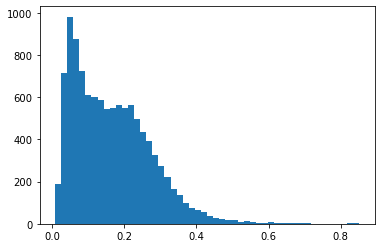

In [39]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [40]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlybestscr.csv', index=False)

## avg last m epochs

In [41]:
m = 3

In [42]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(param.EPOCHS-m, param.EPOCHS):
        sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, sub_fld.target.mean())
        display(sub_fld.head(3))
        lst_sub.append(sub_fld.target.values)

fld 0 epc 7 0.1679258334231831


,image_name,target
0,ISIC_0052060,0.050112
1,ISIC_0052349,0.040255
2,ISIC_0058510,0.047860


fld 0 epc 8 0.14591325753014933


,image_name,target
0,ISIC_0052060,0.028698
1,ISIC_0052349,0.013826
2,ISIC_0058510,0.035221


fld 0 epc 9 0.1498221077016662


,image_name,target
0,ISIC_0052060,0.061489
1,ISIC_0052349,0.036925
2,ISIC_0058510,0.033268


FileNotFoundError: [Errno 2] File ../output/Mel0718A1/submission_Mel0718A1_fld_1_epc_7.csv does not exist: '../output/Mel0718A1/submission_Mel0718A1_fld_1_epc_7.csv'

0.1545537328849997


,image_name,target
0,ISIC_0052060,0.046766
1,ISIC_0052349,0.030335
2,ISIC_0058510,0.038783


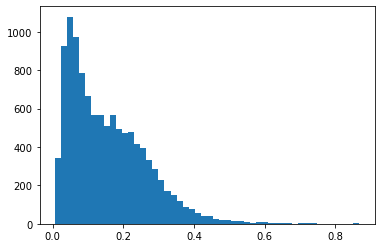

In [43]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [44]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_avglast{m}.csv', index=False)

In [45]:
for m in [2, 3,]:
    print('m',m)
    lst_sub = []
    for fld in param.FLDS2USE:
        for epc in range(param.EPOCHS-m, param.EPOCHS):
            sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
            lst_sub.append(sub_fld.target.values)

    sub = np.mean(lst_sub,0)
    print(sub.mean())
    dfsub.target = sub

    dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_avglast{m}.csv', index=False)

m 2


FileNotFoundError: [Errno 2] File ../output/Mel0718A1/submission_Mel0718A1_fld_1_epc_8.csv does not exist: '../output/Mel0718A1/submission_Mel0718A1_fld_1_epc_8.csv'

# fin

In [46]:
param.__dict__

{'PRFX': 'Mel0718A1',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'ARCH': 'efficientnet-b3',
 'SZ': 512,
 'PRFX_PREP': 'MelPrp0909C512',
 'EPOCHS': 10,
 'BS': 32,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(0, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 20,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': None,
 'DEBUG': False}

In [47]:
!nvidia-smi

Sun Jul 19 18:42:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   53C    P0    47W / 300W |  15900MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  